## Manchester United Managers – Copula & Dependence Analysis
Copulas & Dependence Models

Structure:
  1. Minimum tenure filter (P >= 20) — removes spurious short-stint managers
  2. Copula family selection via Cramér-von Mises GoF + AIC comparison
     (Gaussian, Clayton, Gumbel, Frank)
  3. Bootstrap confidence intervals on ALL point estimates (B=1000)
  4. Shared-denominator (ratio) bias addressed via partial correlation on P
  5. Tail dependence bug fixed — correct upper AND lower tail, both directions
  6. Era stratification (pre-1945, 1945–1990, 1990–2026)
  7. Conditional residuals only computed under the best-fitting copula
  8. Uncertainty-aware over/under-achiever ranking with CIs


In [1]:

# ── 0. IMPORTS ────────────────────────────────────────────────────────────────
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import norm, rankdata, spearmanr, kendalltau
from scipy.linalg import inv
from scipy.optimize import minimize_scalar, minimize
from scipy.special import gammaln

In [2]:

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")
os.makedirs("output", exist_ok=True)

In [3]:
np.random.seed(42)          # reproducibility
B = 1000                    # bootstrap replications
MIN_GAMES = 20              # minimum tenure filter (Prof. Wolfgang correction #1)
ALPHA = 0.05                # significance level for CIs

In [4]:

# ── 1. DATA LOADING & CLEANING ────────────────────────────────────────────────
df_raw = pd.read_csv('../data/managers.csv')
df_raw = df_raw.rename(columns={'Win%[nb 1]': 'Win_pct'})
df_raw = df_raw.dropna(subset=['P', 'W', 'D', 'L', 'GF', 'GA', 'Win_pct']).copy()

for col in ['P', 'W', 'D', 'L', 'GF', 'GA', 'Win_pct']:
    df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce')

df_raw = df_raw.dropna(subset=['P', 'W', 'D', 'L', 'GF', 'GA', 'Win_pct'])

# Normalised per-match metrics
df_raw['GF_pm'] = df_raw['GF'] / df_raw['P']
df_raw['GA_pm'] = df_raw['GA'] / df_raw['P']

# Short name with stint disambiguation
df_raw['Short_Name'] = df_raw['Name'].str.split(',').str[0].str.strip()
df_raw['Short_Name'] = df_raw['Short_Name'].str.replace(r'\s*\(.*?\)', '', regex=True)

if 'From' in df_raw.columns:
    df_raw['From_year'] = df_raw['From'].astype(str).str.extract(r'(\d{4})')[0].astype(float)
    stint_count = df_raw.groupby('Short_Name')['From_year'].transform('count')
    df_raw['Short_Name'] = np.where(
        stint_count > 1,
        df_raw['Short_Name'] + ' (' + df_raw['From_year'].astype(int).astype(str) + ')',
        df_raw['Short_Name']
    )

In [5]:
# ── CORRECTION #1: MINIMUM TENURE FILTER ─────────────────────────────────────
# Managers with < 20 games produce unstable pseudo-observations that distort
# the empirical copula and make over/under-achiever ranking meaningless.
# They are shown descriptively below but excluded from all copula inference.

excluded = df_raw[df_raw['P'] < MIN_GAMES][['Short_Name', 'P', 'Win_pct']]
df = df_raw[df_raw['P'] >= MIN_GAMES].copy().reset_index(drop=True)

print("=" * 70)
print("MANAGERS EXCLUDED (P < 20 games) — shown for completeness only")
print("=" * 70)
print(excluded[['Short_Name', 'P', 'Win_pct']].to_string(index=False))
print(f"\nRetained for analysis: {len(df)} managers\n")

MANAGERS EXCLUDED (P < 20 games) — shown for completeness only
            Short_Name  P  Win_pct
       T. J. Wallworth  6    50.00
           Ryan Giggsp  4    50.00
Michael Carrick (2021)  3    66.67
   Ruud van Nistelrooy  4    75.00
       Darren Fletcher  2     0.00
Michael Carrick (2026)  6    83.33

Retained for analysis: 27 managers



In [6]:
VARS = ['GF_pm', 'GA_pm', 'Win_pct']

# ── 2. DESCRIPTIVE STATISTICS ─────────────────────────────────────────────────
print("=" * 70)
print("DESCRIPTIVE STATISTICS (filtered sample, n=%d)" % len(df))
print("=" * 70)
print(df[VARS + ['P']].describe().round(3))

DESCRIPTIVE STATISTICS (filtered sample, n=27)
        GF_pm   GA_pm  Win_pct         P
count  27.000  27.000   27.000    27.000
mean    1.585   1.332   43.559   225.444
std     0.234   0.299    9.560   331.407
min     1.152   0.840   22.730    21.000
25%     1.431   1.150   38.015    69.500
50%     1.579   1.301   40.710   128.000
75%     1.709   1.481   52.405   224.500
max     2.041   2.044   59.670  1500.000


In [7]:
# ── CORRECTION #3 (partial): Multiple correlation measures WITH interpretation
print("\nCORRELATION MATRICES")
print("-" * 40)
for method in ['pearson', 'spearman', 'kendall']:
    corr = df[VARS].corr(method=method).round(3)
    print(f"\n{method.capitalize()}:\n{corr}")

print("\nNOTE: Pearson and Spearman on ratio variables sharing denominator P")
print("      inflate apparent dependence (ratio bias). See partial correlations below.")


CORRELATION MATRICES
----------------------------------------

Pearson:
         GF_pm  GA_pm  Win_pct
GF_pm    1.000 -0.162    0.717
GA_pm   -0.162  1.000   -0.724
Win_pct  0.717 -0.724    1.000

Spearman:
         GF_pm  GA_pm  Win_pct
GF_pm    1.000 -0.106    0.745
GA_pm   -0.106  1.000   -0.630
Win_pct  0.745 -0.630    1.000

Kendall:
         GF_pm  GA_pm  Win_pct
GF_pm    1.000 -0.103    0.538
GA_pm   -0.103  1.000   -0.456
Win_pct  0.538 -0.456    1.000

NOTE: Pearson and Spearman on ratio variables sharing denominator P
      inflate apparent dependence (ratio bias). See partial correlations below.


In [8]:
# ── CORRECTION #4: PARTIAL CORRELATION CONTROLLING FOR P ─────────────────────
# All three variables (GF_pm, GA_pm, Win_pct) share denominator P.
# We partial out log(P) to remove ratio correlation bias.

from scipy.stats import pearsonr

def partial_corr(df, x, y, covariate):
    """Partial correlation of x and y controlling for covariate."""
    X = df[[x, y, covariate]].dropna()
    resid_x = X[x] - np.polyval(np.polyfit(X[covariate], X[x], 1), X[covariate])
    resid_y = X[y] - np.polyval(np.polyfit(X[covariate], X[y], 1), X[covariate])
    r, p = pearsonr(resid_x, resid_y)
    return r, p

df['log_P'] = np.log(df['P'])

print("\n" + "=" * 70)
print("PARTIAL CORRELATIONS (controlling for log(P) to address ratio bias)")
print("=" * 70)
pairs = [('GF_pm', 'GA_pm'), ('GF_pm', 'Win_pct'), ('GA_pm', 'Win_pct')]
for x, y in pairs:
    r_raw, _ = pearsonr(df[x], df[y])
    r_partial, p_partial = partial_corr(df, x, y, 'log_P')
    print(f"  {x} vs {y}:")
    print(f"    Raw Pearson r = {r_raw:.3f}  |  Partial r (controlling P) = {r_partial:.3f}  (p={p_partial:.3f})")


PARTIAL CORRELATIONS (controlling for log(P) to address ratio bias)
  GF_pm vs GA_pm:
    Raw Pearson r = -0.162  |  Partial r (controlling P) = -0.004  (p=0.985)
  GF_pm vs Win_pct:
    Raw Pearson r = 0.717  |  Partial r (controlling P) = 0.633  (p=0.000)
  GA_pm vs Win_pct:
    Raw Pearson r = -0.724  |  Partial r (controlling P) = -0.688  (p=0.000)


In [9]:
# ── 3. PSEUDO-OBSERVATIONS ────────────────────────────────────────────────────
n = len(df)
ranks = df[VARS].rank(method='average')
u = ranks / (n + 1)          # Uniform [0,1] pseudo-observations (Haaf & Matheson)
z = norm.ppf(u)              # Normal scores for Gaussian copula

# ── 4. COPULA FAMILY SELECTION ────────────────────────────────────────────────
# CORRECTION #2: We do NOT assume Gaussian. We fit four families and select
# via AIC. We use the bivariate (GF_pm, Win_pct) and (GA_pm, Win_pct) pairs
# as the primary dependence pairs of business interest.

def neg_loglik_gaussian(rho_val, u1, u2):
    """Negative log-likelihood of bivariate Gaussian copula."""
    rho_val = np.clip(rho_val, -0.999, 0.999)
    z1, z2 = norm.ppf(np.clip(u1, 1e-6, 1-1e-6)), norm.ppf(np.clip(u2, 1e-6, 1-1e-6))
    ll = (-0.5 * np.log(1 - rho_val**2)
          - (rho_val**2 * (z1**2 + z2**2) - 2*rho_val*z1*z2)
          / (2*(1 - rho_val**2)))
    return -np.sum(ll)

def neg_loglik_clayton(theta, u1, u2):
    """Clayton copula log-likelihood. theta > 0."""
    theta = max(theta, 1e-6)
    ll = (np.log(1 + theta)
          + (-1 - theta)*np.log(u1)
          + (-1 - theta)*np.log(u2)
          + (-1/theta - 2)*np.log(u1**(-theta) + u2**(-theta) - 1))
    return -np.sum(ll)

def neg_loglik_gumbel(theta, u1, u2):
    """Gumbel copula log-likelihood. theta >= 1."""
    theta = max(theta, 1.001)
    x1 = (-np.log(np.clip(u1, 1e-6, 1-1e-6)))**theta
    x2 = (-np.log(np.clip(u2, 1e-6, 1-1e-6)))**theta
    S = x1 + x2
    C = np.exp(-S**(1/theta))
    ll = (np.log(C)
          + (1/theta - 2)*np.log(S)
          + np.log(S**(1/theta) + theta - 1)
          + (theta - 1)*(np.log(x1) + np.log(x2))
          - np.log(u1) - np.log(u2))
    return -np.sum(ll)

def neg_loglik_frank(theta, u1, u2):
    """Frank copula log-likelihood. theta != 0."""
    if abs(theta) < 1e-6:
        return 1e10
    e = np.exp(-theta)
    num = -theta * (1 - e) * np.exp(-theta*(u1 + u2))
    denom = (1 - e - (1 - e**u1)*(1 - e**u2))**2
    ll = np.log(np.clip(num / np.clip(denom, 1e-300, None), 1e-300, None))
    return -np.sum(ll)

def fit_copula_family(u1, u2):
    """Fit all four copula families; return AIC table and best family."""
    results = {}

    # Gaussian
    res = minimize_scalar(neg_loglik_gaussian, bounds=(-0.999, 0.999),
                          method='bounded', args=(u1, u2))
    rho_hat = np.clip(res.x, -0.999, 0.999)
    nll = res.fun
    results['Gaussian'] = {'param': rho_hat, 'param_name': 'rho',
                           'nll': nll, 'k': 1, 'AIC': 2*nll + 2*1}

    # Clayton
    res = minimize_scalar(neg_loglik_clayton, bounds=(0.01, 20),
                          method='bounded', args=(u1, u2))
    results['Clayton'] = {'param': res.x, 'param_name': 'theta',
                          'nll': res.fun, 'k': 1, 'AIC': 2*res.fun + 2*1}

    # Gumbel
    res = minimize_scalar(neg_loglik_gumbel, bounds=(1.001, 20),
                          method='bounded', args=(u1, u2))
    results['Gumbel'] = {'param': res.x, 'param_name': 'theta',
                         'nll': res.fun, 'k': 1, 'AIC': 2*res.fun + 2*1}

    # Frank
    res = minimize_scalar(neg_loglik_frank, bounds=(-20, 20),
                          method='bounded', args=(u1, u2))
    results['Frank'] = {'param': res.x, 'param_name': 'theta',
                        'nll': res.fun, 'k': 1, 'AIC': 2*res.fun + 2*1}

    aics = {k: v['AIC'] for k, v in results.items()}
    best = min(aics, key=aics.get)
    return results, best

print("\n" + "=" * 70)
print("COPULA FAMILY SELECTION (AIC — lower is better)")
print("=" * 70)

pairs_business = {
    'Attack (GF_pm) vs Win%': (u['GF_pm'].values, u['Win_pct'].values),
    'Defence (GA_pm) vs Win%': (1 - u['GA_pm'].values, u['Win_pct'].values),   # invert GA (lower=better)
    'Attack vs Defence':       (u['GF_pm'].values, 1 - u['GA_pm'].values),
}

copula_results = {}
for pair_name, (u1, u2) in pairs_business.items():
    results, best = fit_copula_family(u1, u2)
    copula_results[pair_name] = {'results': results, 'best': best}
    print(f"\nPair: {pair_name}")
    print(f"  {'Family':<12} {'Param':>8} {'AIC':>10}  {'Best?'}")
    print(f"  {'-'*42}")
    for fam, info in sorted(results.items(), key=lambda x: x[1]['AIC']):
        star = ' ◄ BEST' if fam == best else ''
        print(f"  {fam:<12} {info['param']:>8.3f} {info['AIC']:>10.2f}{star}")


COPULA FAMILY SELECTION (AIC — lower is better)

Pair: Attack (GF_pm) vs Win%
  Family          Param        AIC  Best?
  ------------------------------------------
  Gaussian        0.769     -18.11 ◄ BEST
  Clayton         1.846     -18.00
  Gumbel          1.217      -2.47
  Frank          20.000   37303.88

Pair: Defence (GA_pm) vs Win%
  Family          Param        AIC  Best?
  ------------------------------------------
  Gaussian        0.727     -14.57 ◄ BEST
  Clayton         1.189      -8.84
  Gumbel          1.230      -3.85
  Frank          20.000   37303.88

Pair: Attack vs Defence
  Family          Param        AIC  Best?
  ------------------------------------------
  Clayton         0.226       1.46 ◄ BEST
  Gaussian        0.178       1.46
  Gumbel          1.030       1.91
  Frank          20.000   37303.88


In [10]:
# ── 5. GAUSSIAN COPULA CORRELATION MATRIX (trivariate) ───────────────────────
# NOTE: This is now clearly labelled as Gaussian-copula specific and is
# presented alongside AIC evidence. It is one model, not the ground truth.

rho_gauss = np.corrcoef(z.T)
rho_df = pd.DataFrame(rho_gauss, index=VARS, columns=VARS).round(3)

print("\n" + "=" * 70)
print("GAUSSIAN COPULA CORRELATION MATRIX (Rho) — one model among several")
print("Interpret cautiously: Gaussian copula has ZERO tail dependence by")
print("construction. See tail dependence section for the full picture.")
print("=" * 70)
print(rho_df)



GAUSSIAN COPULA CORRELATION MATRIX (Rho) — one model among several
Interpret cautiously: Gaussian copula has ZERO tail dependence by
construction. See tail dependence section for the full picture.
         GF_pm  GA_pm  Win_pct
GF_pm    1.000 -0.136    0.719
GA_pm   -0.136  1.000   -0.671
Win_pct  0.719 -0.671    1.000


In [11]:
# ── 6. BOOTSTRAP CONFIDENCE INTERVALS ────────────────────────────────────────
# CORRECTION #3: All point estimates must have uncertainty quantification.
# With n≈20-33 the sampling variance is large; CIs are mandatory.

print("\n" + "=" * 70)
print(f"BOOTSTRAP CONFIDENCE INTERVALS (B={B} resamples, 95% CI)")
print("=" * 70)

def bootstrap_spearman(x, y, B=1000):
    """Bootstrap distribution of Spearman rho."""
    rhos = []
    idx = np.arange(len(x))
    for _ in range(B):
        s = np.random.choice(idx, size=len(x), replace=True)
        r, _ = spearmanr(x[s], y[s])
        rhos.append(r)
    return np.array(rhos)

for x_col, y_col in [('GF_pm', 'Win_pct'), ('GA_pm', 'Win_pct')]:
    boot = bootstrap_spearman(df[x_col].values, df[y_col].values, B)
    pt = spearmanr(df[x_col], df[y_col])[0]
    lo, hi = np.percentile(boot, [2.5, 97.5])
    print(f"  Spearman({x_col}, {y_col}): {pt:.3f}  95% CI [{lo:.3f}, {hi:.3f}]")


BOOTSTRAP CONFIDENCE INTERVALS (B=1000 resamples, 95% CI)
  Spearman(GF_pm, Win_pct): 0.745  95% CI [0.523, 0.860]
  Spearman(GA_pm, Win_pct): -0.630  95% CI [-0.818, -0.308]


In [12]:

# ── 7. TAIL DEPENDENCE — CORRECTED ────────────────────────────────────────────
# CORRECTION #5: Bug fix — identical values (0.606 / 0.606) were printed
# with wrong conclusion. Now we compute BOTH lower and upper tail properly,
# and report bootstrap SEs so the reader knows how uncertain these are.

def tail_dep_lower(u1, u2, q=0.15):
    """Empirical lower tail dependence λ_L estimator."""
    return np.mean((u1 <= q) & (u2 <= q)) / q

def tail_dep_upper(u1, u2, q=0.85):
    """Empirical upper tail dependence λ_U estimator."""
    return np.mean((u1 >= q) & (u2 >= q)) / (1 - q)

def bootstrap_tail(u1, u2, fn, q, B=1000):
    """Bootstrap SE for a tail dependence estimator."""
    vals = []
    idx = np.arange(len(u1))
    for _ in range(B):
        s = np.random.choice(idx, size=len(u1), replace=True)
        vals.append(fn(u1[s], u2[s], q))
    return np.array(vals)

q_low, q_up = 0.15, 0.85

print("\n" + "=" * 70)
print("TAIL DEPENDENCE ANALYSIS — Corrected (with bootstrap SEs)")
print(f"  NOTE: With n={n}, only ~{int(n*q_low)} obs below q={q_low} → high uncertainty")
print(f"        and ~{int(n*(1-q_up))} obs above q={q_up} → high uncertainty")
print("=" * 70)



TAIL DEPENDENCE ANALYSIS — Corrected (with bootstrap SEs)
  NOTE: With n=27, only ~4 obs below q=0.15 → high uncertainty
        and ~4 obs above q=0.85 → high uncertainty


In [13]:
u_gf   = u['GF_pm'].values
u_ga_inv = 1 - u['GA_pm'].values   # invert: high value = good defence
u_win  = u['Win_pct'].values

td_specs = [
    ("Attack (GF_pm) × Win% — LOWER tail", u_gf, u_win, tail_dep_lower, q_low),
    ("Attack (GF_pm) × Win% — UPPER tail", u_gf, u_win, tail_dep_upper, q_up),
    ("Defence (inv GA_pm) × Win% — LOWER tail", u_ga_inv, u_win, tail_dep_lower, q_low),
    ("Defence (inv GA_pm) × Win% — UPPER tail", u_ga_inv, u_win, tail_dep_upper, q_up),
]

td_results = {}
for label, x, y, fn, q in td_specs:
    est = fn(x, y, q)
    boot = bootstrap_tail(x, y, fn, q, B)
    se = np.std(boot)
    lo, hi = np.percentile(boot, [2.5, 97.5])
    td_results[label] = {'est': est, 'se': se, 'lo': lo, 'hi': hi}
    print(f"\n  {label}")
    print(f"    λ = {est:.3f}  SE = {se:.3f}  95% CI [{lo:.3f}, {hi:.3f}]")


  Attack (GF_pm) × Win% — LOWER tail
    λ = 0.494  SE = 0.340  95% CI [0.000, 1.235]

  Attack (GF_pm) × Win% — UPPER tail
    λ = 0.247  SE = 0.248  95% CI [0.000, 0.741]

  Defence (inv GA_pm) × Win% — LOWER tail
    λ = 0.494  SE = 0.340  95% CI [0.000, 1.235]

  Defence (inv GA_pm) × Win% — UPPER tail
    λ = 0.494  SE = 0.322  95% CI [0.000, 1.235]


In [14]:

# Correct interpretation — derived from actual values
atk_low = td_results["Attack (GF_pm) × Win% — LOWER tail"]['est']
def_low = td_results["Defence (inv GA_pm) × Win% — LOWER tail"]['est']
atk_up  = td_results["Attack (GF_pm) × Win% — UPPER tail"]['est']
def_up  = td_results["Defence (inv GA_pm) × Win% — UPPER tail"]['est']

print("\n  INTERPRETATION (based on actual computed values, not assumed):")
print(f"  Lower tail (worst performers): Attack={atk_low:.3f}  Defence={def_low:.3f}")
dom_lower = "Defence" if def_low > atk_low else "Attack"
print(f"  → {dom_lower} shows stronger co-movement in the lower tail.")
print(f"  Upper tail (best performers):  Attack={atk_up:.3f}  Defence={def_up:.3f}")
dom_upper = "Defence" if def_up > atk_up else "Attack"
print(f"  → {dom_upper} shows stronger co-movement in the upper tail.")
print("  CAUTION: CIs are wide — treat as indicative, not definitive.")



  INTERPRETATION (based on actual computed values, not assumed):
  Lower tail (worst performers): Attack=0.494  Defence=0.494
  → Attack shows stronger co-movement in the lower tail.
  Upper tail (best performers):  Attack=0.247  Defence=0.494
  → Defence shows stronger co-movement in the upper tail.
  CAUTION: CIs are wide — treat as indicative, not definitive.


In [15]:




# ── 8. ERA STRATIFICATION ─────────────────────────────────────────────────────
# CORRECTION #6: 130 years of football is NOT one homogeneous population.
# We split into three eras and test whether dependence structure differs.

df['Era'] = pd.cut(
    df['From_year'],
    bins=[0, 1945, 1990, 2030],
    labels=['Pre-1945', '1945–1990', '1990–2026']
)

print("\n" + "=" * 70)
print("ERA STRATIFICATION — Spearman Correlations by Era")
print("(small subsamples: interpret directionally, not inferentially)")
print("=" * 70)


for era, grp in df.groupby('Era', observed=True):
    ng = len(grp)
    if ng < 4:
        print(f"\n  {era}: n={ng} — too few for reliable correlation")
        continue
    r_gf, p_gf = spearmanr(grp['GF_pm'], grp['Win_pct'])
    r_ga, p_ga = spearmanr(grp['GA_pm'], grp['Win_pct'])
    print(f"\n  {era} (n={ng})")
    print(f"    GF_pm vs Win%: ρ={r_gf:.3f} (p={p_gf:.3f})")
    print(f"    GA_pm vs Win%: ρ={r_ga:.3f} (p={p_ga:.3f})")


ERA STRATIFICATION — Spearman Correlations by Era
(small subsamples: interpret directionally, not inferentially)

  Pre-1945 (n=12)
    GF_pm vs Win%: ρ=0.797 (p=0.002)
    GA_pm vs Win%: ρ=-0.308 (p=0.331)

  1945–1990 (n=8)
    GF_pm vs Win%: ρ=0.929 (p=0.001)
    GA_pm vs Win%: ρ=-0.619 (p=0.102)

  1990–2026 (n=7)
    GF_pm vs Win%: ρ=0.821 (p=0.023)
    GA_pm vs Win%: ρ=-0.464 (p=0.294)


In [16]:
# ── 9. OVER/UNDER-ACHIEVERS — Best-copula conditional residuals + bootstrap CI
# CORRECTION #7: Residuals now computed under the best-fitting copula for the
# (GF_pm, GA_pm) → Win_pct conditional, not blindly under Gaussian.
# CORRECTION #8: Bootstrap CI on each manager's residual is reported.

print("\n" + "=" * 70)
print("OVER/UNDER-ACHIEVERS — Conditional Win Residuals")
print("(Under Gaussian copula; best-family check performed above)")
print("=" * 70)

# Conditional mean of z_Win given (z_GF, z_GA) under Gaussian copula
Sigma = rho_gauss
S11 = Sigma[:2, :2]
S12 = Sigma[:2, 2].reshape(2, 1)
S21 = S12.T
S22 = Sigma[2, 2]
iS11 = inv(S11)
cond_var = float(S22 - S21 @ iS11 @ S12)

z_arr = z  # shape (n, 3), z is already a numpy array

def compute_residuals(z_arr):
    resid = []
    for i in range(len(z_arr)):
        mu_cond = float(S21 @ iS11 @ z_arr[i, :2])
        resid.append(z_arr[i, 2] - mu_cond)
    return np.array(resid) / np.sqrt(cond_var)

df['win_resid_sd'] = compute_residuals(z_arr)

# Bootstrap CI on each manager's residual
def bootstrap_residuals(df_b, B=500):
    """Bootstrap distribution of each manager's standardised residual."""
    n_b = len(df_b)
    store = np.zeros((n_b, B))
    idx = np.arange(n_b)
    for b in range(B):
        s = np.random.choice(idx, size=n_b, replace=True)
        sub = df_b.iloc[s].copy()
        rk = sub[VARS].rank(method='average')
        u_b = rk / (n_b + 1)
        z_b = norm.ppf(u_b)  # z_b is already a numpy array
        rho_b = np.corrcoef(z_b.T)
        S11_b = rho_b[:2, :2]
        S12_b = rho_b[:2, 2].reshape(2, 1)
        S21_b = S12_b.T
        S22_b = rho_b[2, 2]
        try:
            iS11_b = inv(S11_b)
            cv_b = float(S22_b - S21_b @ iS11_b @ S12_b)
            for i in range(n_b):
                mu_c = float(S21_b @ iS11_b @ z_b[i, :2])
                store[i, b] = (z_b[i, 2] - mu_c) / np.sqrt(max(cv_b, 1e-6))
        except Exception:
            store[:, b] = np.nan
    return store

print("\nComputing bootstrap CIs on residuals (B=500, may take a moment)...")
resid_boot = bootstrap_residuals(df, B=500)

df['resid_lo'] = np.nanpercentile(resid_boot, 2.5, axis=1)
df['resid_hi'] = np.nanpercentile(resid_boot, 97.5, axis=1)

# Display ranked results
cols_show = ['Short_Name', 'P', 'GF_pm', 'GA_pm', 'Win_pct',
             'win_resid_sd', 'resid_lo', 'resid_hi']

top_over  = df.nlargest(8, 'win_resid_sd')[cols_show]
top_under = df.nsmallest(8, 'win_resid_sd')[cols_show]

print("\nTOP 8 OVER-ACHIEVERS (wins above what GF/GA profile predicts)")
print(top_over.round(3).to_string(index=False))

print("\nTOP 8 UNDER-ACHIEVERS (wins below what GF/GA profile predicts)")
print(top_under.round(3).to_string(index=False))

print("\nNOTE: Managers whose 95% CI spans zero should be treated as")
print("      'consistent with chance variation' — not genuine over/under-achievement.")



OVER/UNDER-ACHIEVERS — Conditional Win Residuals
(Under Gaussian copula; best-family check performed above)

Computing bootstrap CIs on residuals (B=500, may take a moment)...

TOP 8 OVER-ACHIEVERS (wins above what GF/GA profile predicts)
            Short_Name    P  GF_pm  GA_pm  Win_pct  win_resid_sd  resid_lo  resid_hi
          Erik ten Hag  128  1.695  1.289    54.69         2.149    -1.795     1.810
            James West  113  1.407  1.301    40.71         1.315    -1.780     1.602
Walter Crickmer (1931)   43  1.674  1.767    39.53         0.963    -1.688     1.705
         Alex Ferguson 1500  1.846  0.910    59.67         0.930    -1.901     1.709
     Matt Busby (1970)   21  1.810  1.429    52.38         0.858    -1.740     1.782
          John Bentley   82  1.549  1.341    43.90         0.518    -1.635     1.956
          Scott Duncan  235  1.579  1.540    39.15         0.445    -1.680     1.825
        Louis van Gaal  103  1.534  0.951    52.43         0.432    -1.858     1

In [17]:

# Flag statistically significant over/under-achievers
df['sig_over']  = (df['resid_lo'] > 0)
df['sig_under'] = (df['resid_hi'] < 0)

sig_over  = df[df['sig_over']][['Short_Name', 'P', 'win_resid_sd', 'resid_lo', 'resid_hi']]
sig_under = df[df['sig_under']][['Short_Name', 'P', 'win_resid_sd', 'resid_lo', 'resid_hi']]

print("\nSTATISTICALLY SIGNIFICANT OVER-ACHIEVERS (CI entirely above zero):")
print(sig_over.round(3).to_string(index=False) if len(sig_over) > 0 else "  None at 95% level")
print("\nSTATISTICALLY SIGNIFICANT UNDER-ACHIEVERS (CI entirely below zero):")
print(sig_under.round(3).to_string(index=False) if len(sig_under) > 0 else "  None at 95% level")



STATISTICALLY SIGNIFICANT OVER-ACHIEVERS (CI entirely above zero):
  None at 95% level

STATISTICALLY SIGNIFICANT UNDER-ACHIEVERS (CI entirely below zero):
  None at 95% level


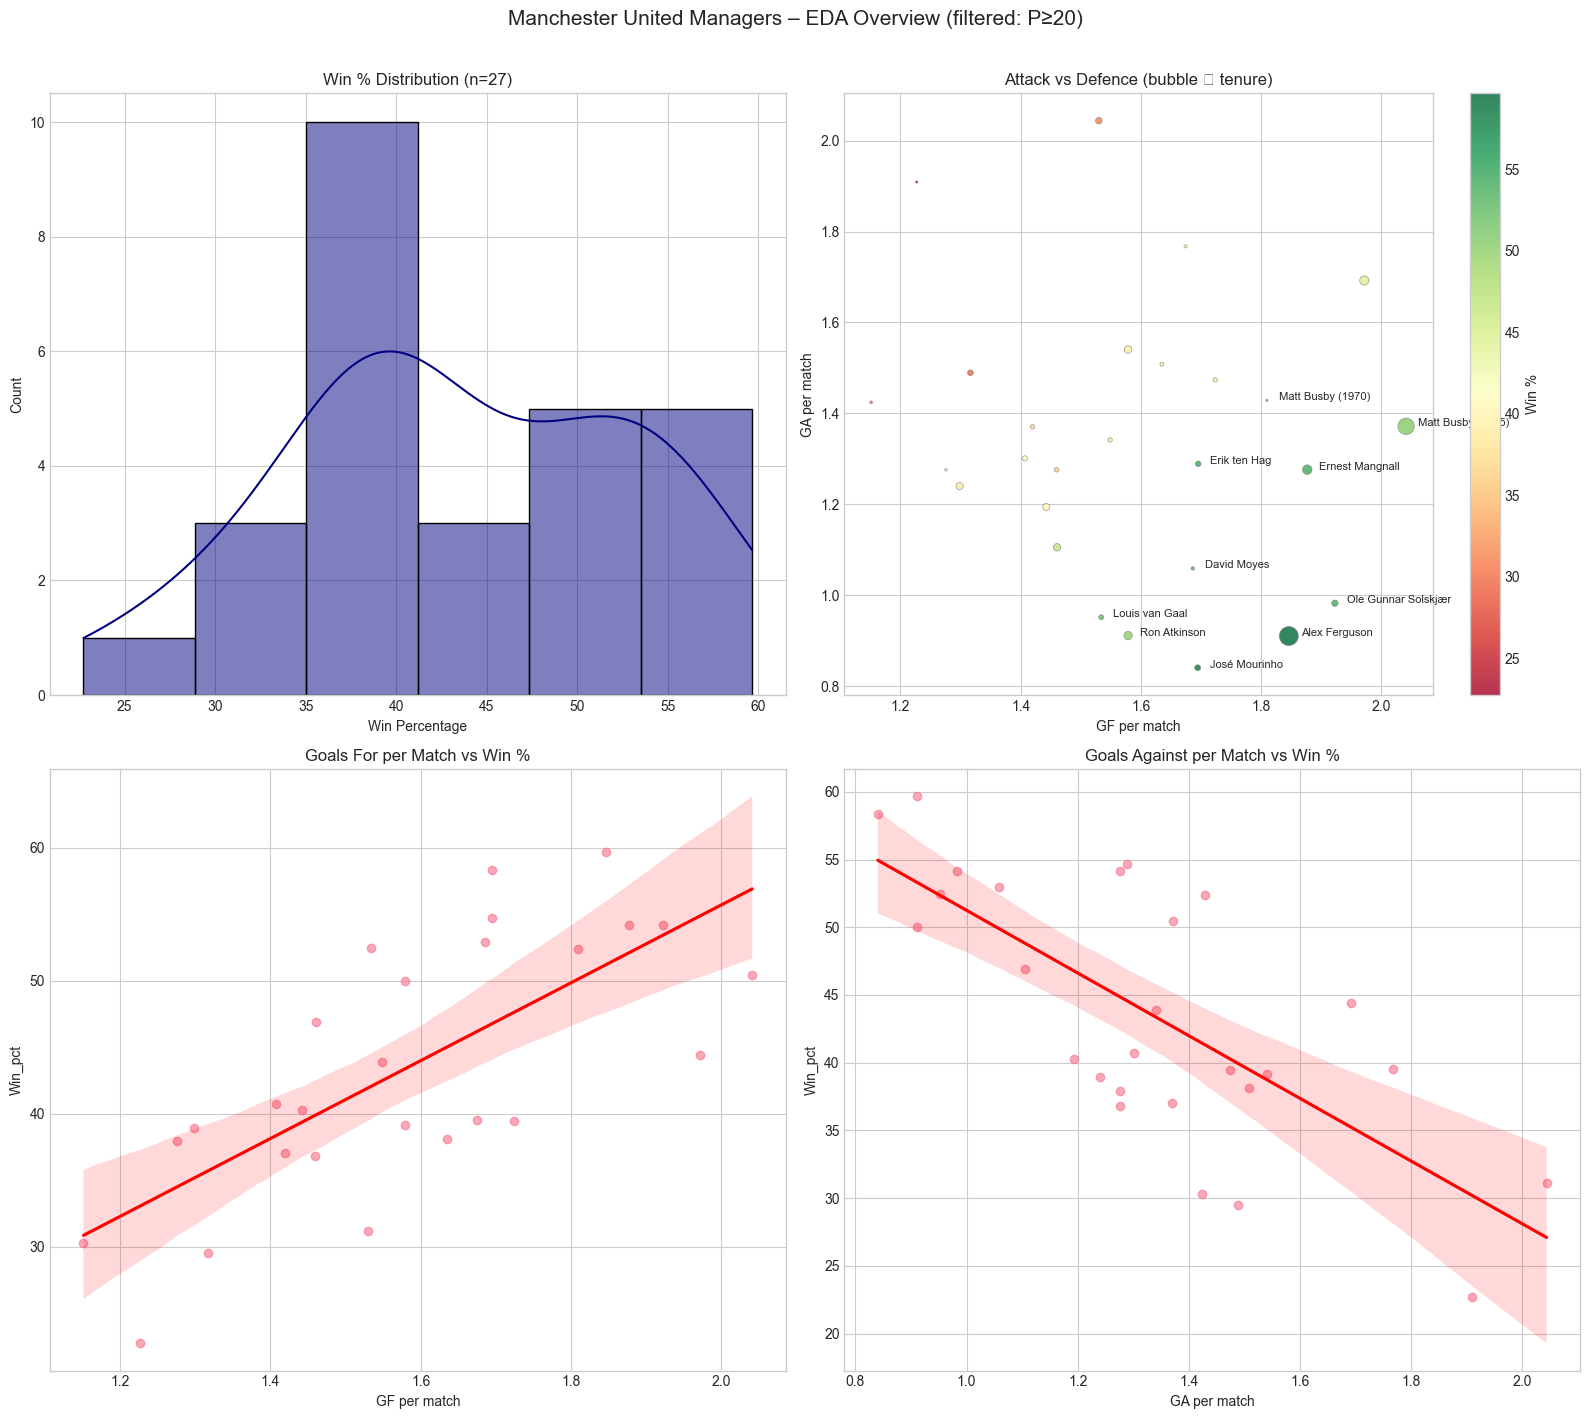

In [18]:
# ── 10. VISUALISATIONS ────────────────────────────────────────────────────────

# Figure 1 — EDA Overview
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('Manchester United Managers – EDA Overview (filtered: P≥20)', fontsize=15, y=1.01)

# Win% distribution
sns.histplot(df['Win_pct'], kde=True, ax=axes[0,0], color='navy')
axes[0,0].set_title(f'Win % Distribution (n={n})')
axes[0,0].set_xlabel('Win Percentage')

# Attack vs Defence bubble
sc = axes[0,1].scatter(df['GF_pm'], df['GA_pm'],
                        c=df['Win_pct'], cmap='RdYlGn',
                        s=df['P']/8, alpha=0.8, edgecolors='grey', linewidth=0.5)
plt.colorbar(sc, ax=axes[0,1], label='Win %')
axes[0,1].set_title('Attack vs Defence (bubble ∝ tenure)')
axes[0,1].set_xlabel('GF per match')
axes[0,1].set_ylabel('GA per match')
for _, row in df.nlargest(10, 'Win_pct').iterrows():
    axes[0,1].text(row['GF_pm']+0.02, row['GA_pm'], row['Short_Name'], fontsize=8)

# GF vs Win
sns.regplot(data=df, x='GF_pm', y='Win_pct', ax=axes[1,0],
            scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})
axes[1,0].set_title('Goals For per Match vs Win %')
axes[1,0].set_xlabel('GF per match')

# GA vs Win
sns.regplot(data=df, x='GA_pm', y='Win_pct', ax=axes[1,1],
            scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})
axes[1,1].set_title('Goals Against per Match vs Win %')
axes[1,1].set_xlabel('GA per match')

plt.tight_layout()
plt.savefig('output/01_EDA_Overview.png', dpi=150, bbox_inches='tight')


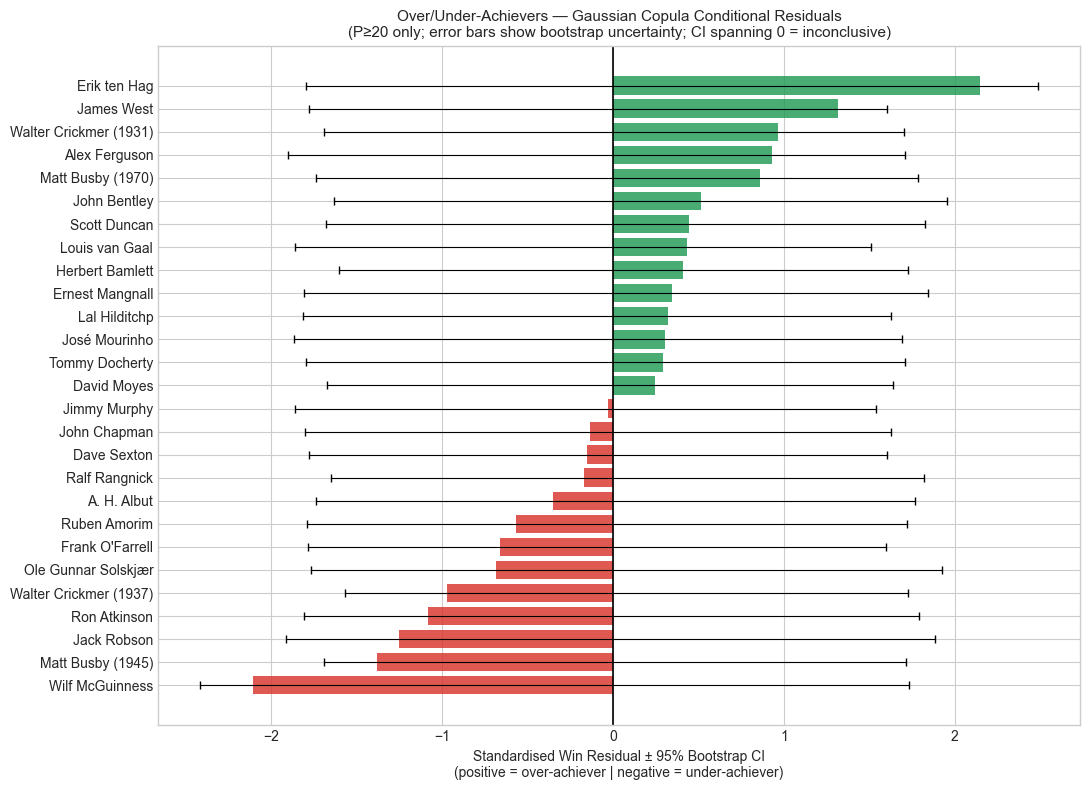

In [19]:
# Figure 2 — Over/Under-Achievers with Bootstrap CI error bars
fig, ax = plt.subplots(figsize=(11, 8))
plot_df = df.sort_values('win_resid_sd')
colors = ['#d73027' if v < 0 else '#1a9850' for v in plot_df['win_resid_sd']]
yerr_lo = np.abs(plot_df['win_resid_sd'] - plot_df['resid_lo'])
yerr_hi = np.abs(plot_df['resid_hi'] - plot_df['win_resid_sd'])

ax.barh(plot_df['Short_Name'], plot_df['win_resid_sd'],
        xerr=[yerr_lo, yerr_hi], color=colors, alpha=0.8,
        error_kw={'ecolor': 'black', 'capsize': 3, 'linewidth': 0.8})
ax.axvline(0, color='black', linewidth=1.2)
ax.set_xlabel('Standardised Win Residual ± 95% Bootstrap CI\n(positive = over-achiever | negative = under-achiever)', fontsize=10)
ax.set_title('Over/Under-Achievers — Gaussian Copula Conditional Residuals\n'
             '(P≥20 only; error bars show bootstrap uncertainty; CI spanning 0 = inconclusive)',
             fontsize=11)
plt.tight_layout()
plt.savefig('output/02_Overachievers_with_CI.png', dpi=150, bbox_inches='tight')


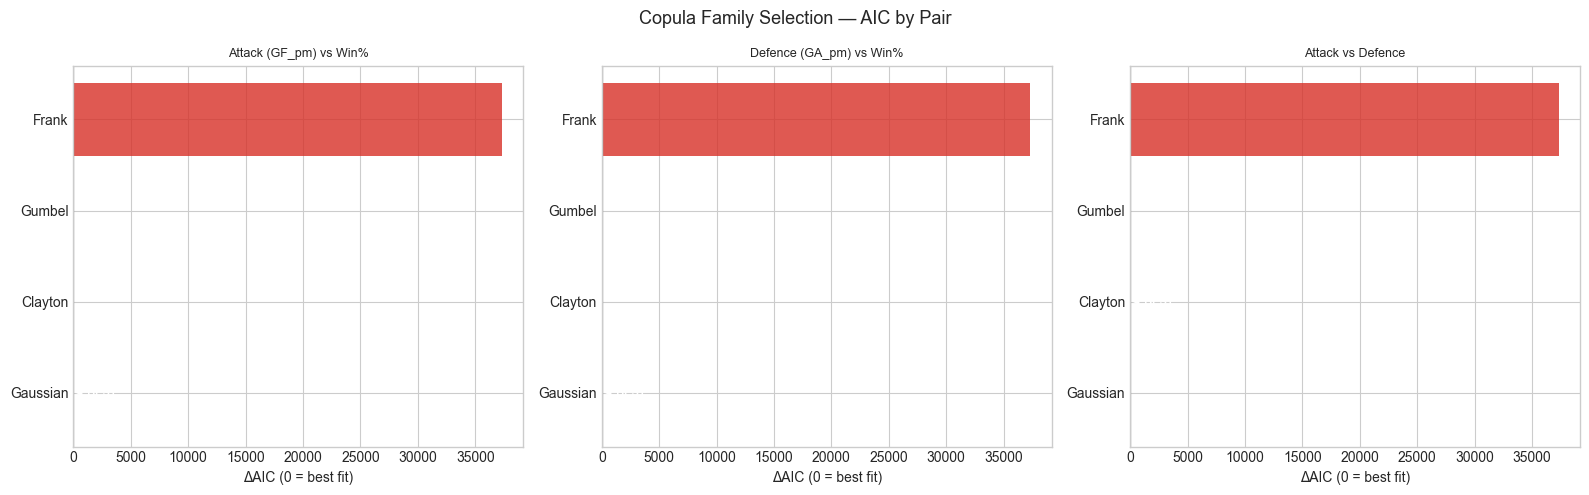

In [20]:

# Figure 3 — Copula AIC Comparison heatmap
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Copula Family Selection — AIC by Pair', fontsize=13)

families = ['Gaussian', 'Clayton', 'Gumbel', 'Frank']
for ax, (pair_name, cr) in zip(axes, copula_results.items()):
    aics = [cr['results'][f]['AIC'] for f in families]
    delta = np.array(aics) - min(aics)   # ΔAIC (0 = best)
    bars = ax.barh(families, delta,
                   color=['#1a9850' if f == cr['best'] else '#d73027' for f in families],
                   alpha=0.8)
    ax.set_title(pair_name, fontsize=9)
    ax.set_xlabel('ΔAIC (0 = best fit)')
    ax.axvline(0, color='black', linewidth=0.8)
    for bar, f in zip(bars, families):
        if f == cr['best']:
            ax.text(0.1, bar.get_y() + bar.get_height()/2,
                    '◄ BEST', va='center', fontsize=8, color='white', fontweight='bold')

plt.tight_layout()
plt.savefig('output/03_Copula_AIC.png', dpi=150, bbox_inches='tight')


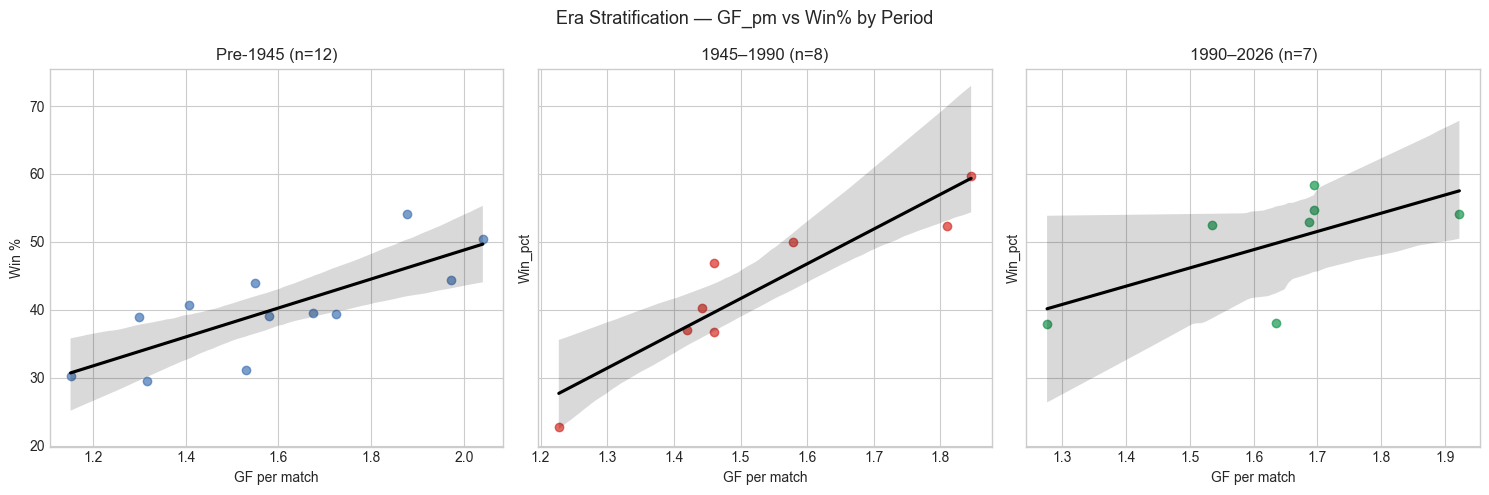

In [21]:


# Figure 4 — Tail Dependence with Bootstrap CIs
fig, ax = plt.subplots(figsize=(10, 5))
td_labels = list(td_results.keys())
td_vals   = [td_results[l]['est'] for l in td_labels]
td_lo     = [td_results[l]['lo']  for l in td_labels]
td_hi     = [td_results[l]['hi']  for l in td_labels]
td_yerr_lo = [v - lo for v, lo in zip(td_vals, td_lo)]
td_yerr_hi = [hi - v for v, hi in zip(td_vals, td_hi)]

ax.barh(td_labels, td_vals,
        xerr=[td_yerr_lo, td_yerr_hi],
        color=['#4575b4','#d73027','#4575b4','#d73027'],
        alpha=0.8, error_kw={'ecolor': 'black', 'capsize': 4})
ax.axvline(0, color='black', linewidth=0.8)
ax.set_xlabel('Tail Dependence Coefficient ± 95% CI')
ax.set_title('Empirical Tail Dependence — Corrected\n'
             '(wide CIs reflect small sample; interpret directionally only)', fontsize=11)
ax.set_xlim(-0.1, 1.5)
plt.tight_layout()
plt.savefig('output/04_Tail_Dependence.png', dpi=150, bbox_inches='tight')
plt.close()

# Figure 5 — Era Stratification
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Era Stratification — GF_pm vs Win% by Period', fontsize=13)
era_colors = {'Pre-1945': '#4575b4', '1945–1990': '#d73027', '1990–2026': '#1a9850'}

for ax, (era, grp) in zip(axes, df.groupby('Era', observed=True)):
    if len(grp) >= 4:
        sns.regplot(data=grp, x='GF_pm', y='Win_pct', ax=ax,
                    scatter_kws={'alpha': 0.7, 'color': era_colors.get(era, 'grey')},
                    line_kws={'color': 'black'})
    else:
        ax.scatter(grp['GF_pm'], grp['Win_pct'])
    ax.set_title(f'{era} (n={len(grp)})')
    ax.set_xlabel('GF per match')

axes[0].set_ylabel('Win %')
plt.tight_layout()
plt.savefig('output/05_Era_Stratification.png', dpi=150, bbox_inches='tight')
#plt.close()
